In this notebook we will be utilizing OpenCV to perform image registration that is mapping the of different images of one scene onto the same scene with a different coordinate system. The images we will be working with involve clothing whose text need to be mapped and compared with. One image is captured with a full frontal representation which we will be identifying as our reference image and the other image is of the same clothing that is depicted in an aligned fashion.

> As mentioned earlier our goal is to develop a mapping between the textual portions of these two images using OpenCV.



> We will be using Google Colab with the GPU enabled to minimize the compute time.





In [6]:
#Importing the images that are to be processed
from google.colab import files
img_1 = files.upload()   #The image that is aligned on its axis

Saving align_img.png to align_img.png


In [8]:
from google.colab import files
img_2 = files.upload()   #the reference image 

Saving ref_img.png to ref_img.png


Since we will be using the SIFT and SURF amtching algorithms later on we will be the specific versions of opencv and opencv-contrib to be installed during our runtime for being able to access these algorithms in an open source fashion. So if there arises at any time the error stating "error: OpenCV(3.4.3) /io/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1207: error: (-213:The function/feature is not implemented)" execute the following code and restart the runtime and it will work immediately.

In [4]:
!pip install opencv-python==3.4.2.16 
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 1.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20


     |████████████████████████████████| 30.6MB 1.5MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


In [0]:
#Importing the libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

Since Jupyter Notebooks have errors with the 'cv2.imshow()' function (because of it crashing the kernel) we have developed our own function for displaying the images which performs the same way as imshow() but instead uses the matplotlib.pyplot library.

In [0]:
#Function to display the images that have been passed to it and displays the image with the title 
def cv2_imshow_mpl(a, title=None):
    plt.figure(figsize = (12, 12))
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    if title:
        plt.title(title)
    plt.imshow(a)

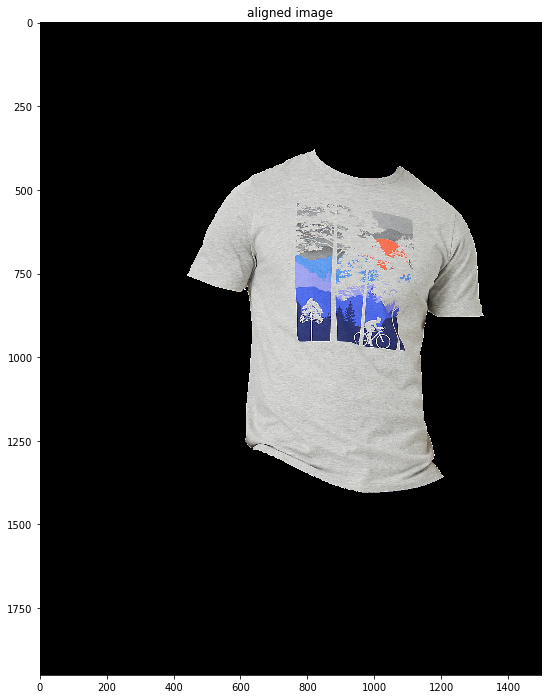

In [6]:
#Reading the images that have been imported into Colab
align_img = cv2.imread("align_img.png")
ref_img = cv2.imread("ref_img.png")

#visualizing our aligned image
cv2_imshow_mpl(align_img, 'aligned image')

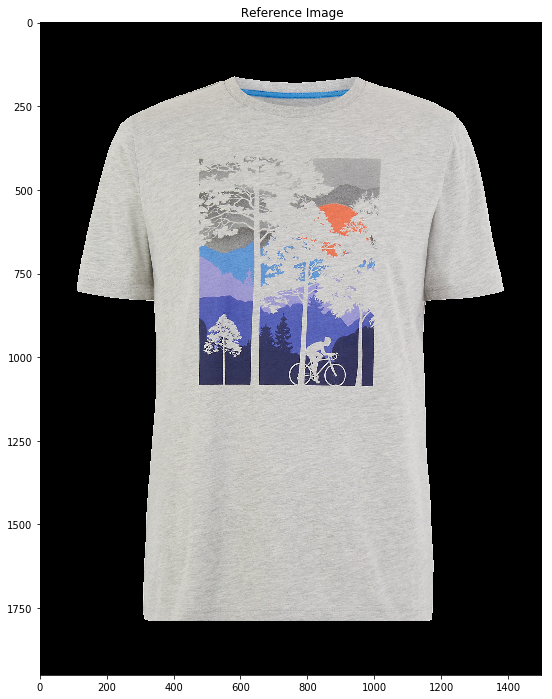

In [13]:
#Visualizing our reference image
cv2_imshow_mpl(ref_img, ' Reference Image')

First we are going with the method of feature detection to identify the features and their respective descriptors in the aligned image. By identifying the features we can get a rough idea of the points that will be identified by the detection algorithm and this algorithm can then be used for the matching. We are employing this detection method only on the aligned image so that we can see if the text on the clothing piece are identified as points in the feature list. We have used both the SURF and SIFT algorithm as they are the best algorithms that are available for detection. We will be doing a comparision exeriement between the two methods.

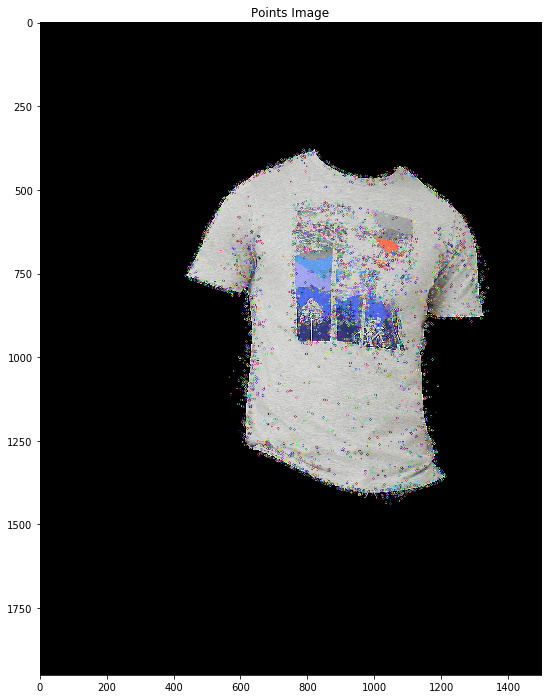

In [7]:
# Feature Detection using surf method
surf = cv2.xfeatures2d.SURF_create()
keypoints_surf, descriptors = surf.detectAndCompute(align_img, None)

align_img_points = cv2.drawKeypoints(align_img, keypoints_surf, None)
cv2_imshow_mpl(align_img_points, "Points Image")

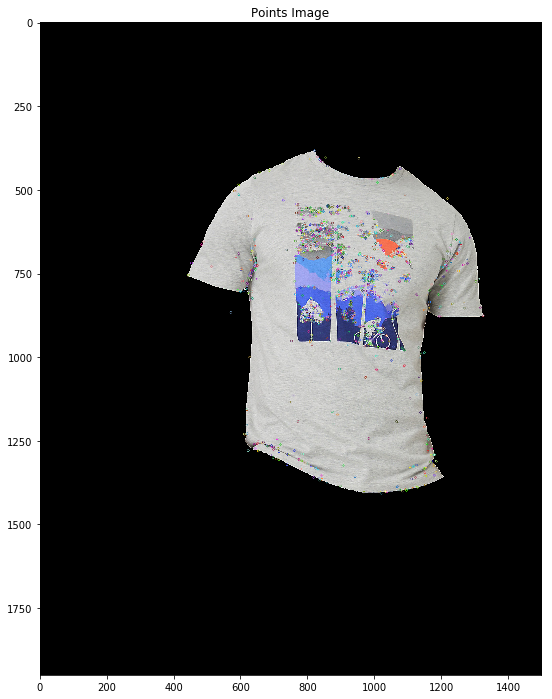

In [8]:
# Feature Detection using sift method
sift = cv2.xfeatures2d.SIFT_create()
keypoints_sift, descriptors = sift.detectAndCompute(align_img, None)

align_img_points = cv2.drawKeypoints(align_img, keypoints_sift, None)
cv2_imshow_mpl(align_img_points, "Points Image")

As we can see from the two plots above the SURF method has done a better job at identifying not only the text on the clothing but also the boundaries of the clothing and it has identified a lot more points than the SIFT method. 

Now that we will be implementing the feature matching or image registration we can explain the methodology  that we will be employing. Just as in the feature detection stage since we did the comparision with SIFT and SURF, here too we will be employing the same methodolgy. We have also opted to go with the implementation of homography to see the effects it can have on the matching of the points in the two images.


> For the classification task we have opted to go with K-Nearest Neighbour approach. Specifically we have opted to with the OpenCV library called the FLANN based Matcher (Fast Library for Approximate Nearest Neighbor Approach). This library contains a collection of algorithms optimized for performing KNN on large dataset. We have also employed homography as a way to detect the detect the plane that the aligned image is in with respect to the reference image and we have highlighted this plane with a white border. 



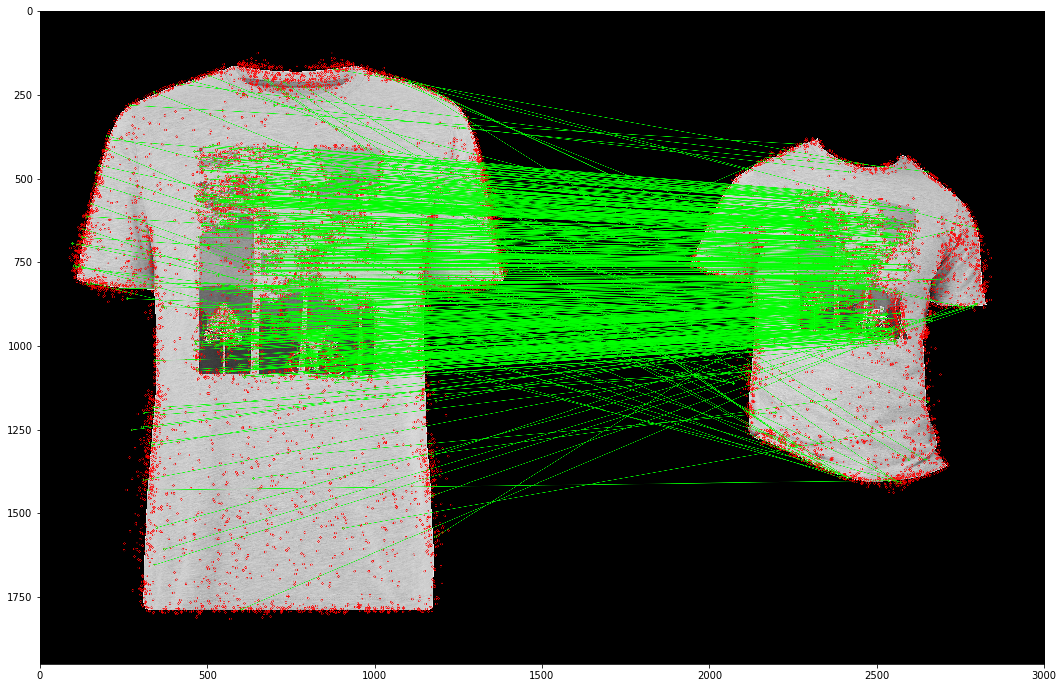

(<matplotlib.image.AxesImage at 0x7f50b42f8470>, None)

In [11]:
#This is the implmentation of the feature matching using the SURF algorithm using the SURF algorithm
img1 = cv2.imread('ref_img.png',0)          # queryImage
img2 = cv2.imread('align_img.png',0) # trainImage

# Initiate SIFT detector
surf = cv2.xfeatures2d.SURF_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = surf.detectAndCompute(img1,None)
kp2, des2 = surf.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.figure(figsize = (18, 18))
plt.imshow(img3,),plt.show()

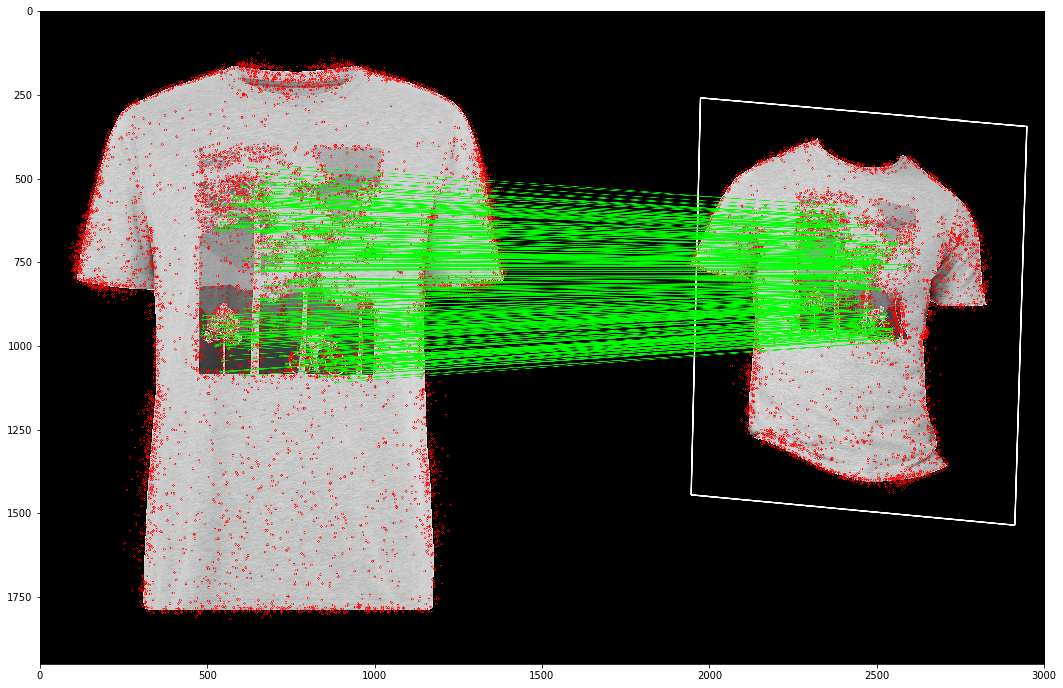

(<matplotlib.image.AxesImage at 0x7f54f61f4240>, None)

In [27]:
#this is the implementation of the feature matching of the aligned image and the reference image using the SURF algorithm with homography

img1 = cv2.imread('ref_img.png',0)          # queryImage
img2 = cv2.imread('align_img.png',0) # trainImage

#Initiate the SIFT detector
surf = cv2.xfeatures2d.SURF_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = surf.detectAndCompute(img1,None)
kp2, des2 = surf.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
MIN_MATCH_COUNT = 10
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
#matchesMask = [[0,0] for i in range(len(matches))]
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

# ratio test as per Lowe's paper
#for i,(m,n) in enumerate(matches):
#    if m.distance < 0.7*n.distance:
#        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize = (18, 18))
plt.imshow(img3,),plt.show()

!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

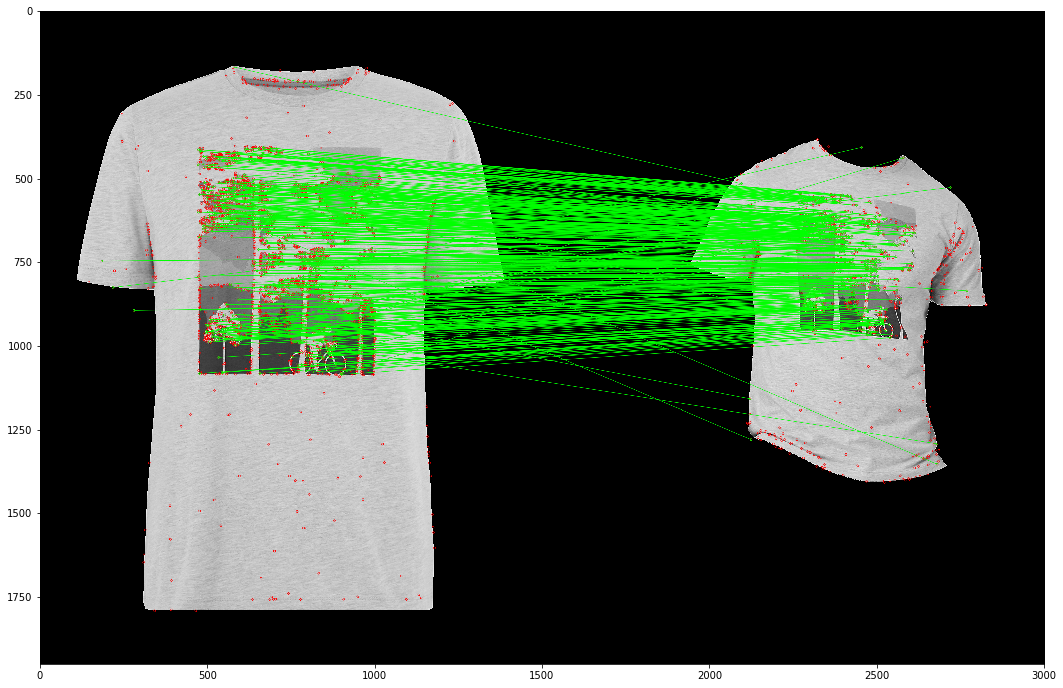

(<matplotlib.image.AxesImage at 0x7f54f6294588>, None)

In [29]:
#this is the implementation of the feature matching using SIFT matching algorithm

img1 = cv2.imread('ref_img.png',0)          # queryImage
img2 = cv2.imread('align_img.png',0) # trainImage

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.figure(figsize = (18, 18))
plt.imshow(img3,),plt.show()

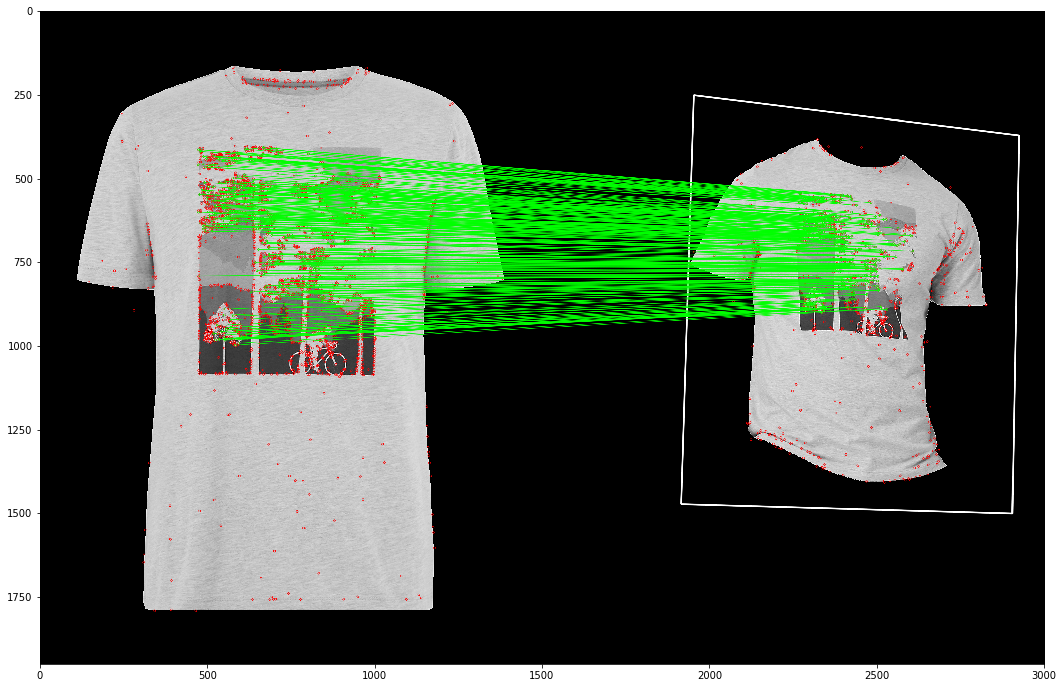

(<matplotlib.image.AxesImage at 0x7f50bf2fbc88>, None)

In [12]:
#This is the implementation of the feature matching of the aligned image and the reference image using SIFT with homography

img1 = cv2.imread('ref_img.png',0)          # queryImage
img2 = cv2.imread('align_img.png',0) # trainImage

#Initiate the SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
MIN_MATCH_COUNT = 10
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
#matchesMask = [[0,0] for i in range(len(matches))]
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

# ratio test as per Lowe's paper
#for i,(m,n) in enumerate(matches):
#    if m.distance < 0.7*n.distance:
#        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize = (18, 18))
plt.imshow(img3,),plt.show()

As we have observed with the plots we can see that the SURF algorithm is much more optimal at the feature detection with identifying much more features not only of the text but also the boudaries of the clothing as well. The SIFT technique can be used when and only when we want to identify the specific pictorial representations amongst the clothing pieces. 


> The most optimal techinque to go with would be the SURF technique couplped with homography as the depiction shows that the method has identified and mapped successfully minute details such as the cyclist, tree. The benefit of this method is that it has recognised the entire reference image portion in the aligned image and has put the border in the same angle as the angle the aligned image is in. With further tuning we can map the boundaries of the shirt of both images instead of having the entire reference image being mapped to the aligned image. But since a large portion of the mappings are performed successfully for the text and pictures we can know that the method has been successful.



> Without the addition of homography we can see that there are a large number of wrongful mappings that have been performed for both SIFT and SURF where in we can see that the boundaries of the shirt have been mapped onto the pictorial part of the shirt etc. Having such an incorrect mapping would result in a lot of error in later classification hence the SURF method with homography is the best method for this specific application



